# Plot SWOT SWORD of Science River Dischage with Gauge Data

In [17]:
import netCDF4
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.pyplot as plt
import datetime

## Looking at discharge in the SoS

It can be helpful to plot the flow law parameter estimation (FLPE) algorithm discharge alongside the integrator (MOI) discharge produced for that algorithm PLUS overlapping in situ gauge data. Note that not all rivers have gauge data associated with them. In this notebook we will look at the steps to plot SoS discharge values produced from running the Confluence workflow alongside in situ gauge data gathered and stored in the priors.

## Granule structure (background)

The SWORD of Science (SoS) is a community-driven dataset produced for and from the execution of the Confluence workflow in the cloud which enables quick data access and compute on SWOT data. Data granules contain two files, priors and results. The priors file contains prior information, such as in-situ gage data and model output that is used to generate the discharge products. The results file contains the resulting river discharge data products.

The SoS is organized by continent following [SWOT River Database (SWORD)](https://www.swordexplorer.com/) structure and naming conventions. It is indexed on the same reach and node identifier dimensions found in SWORD. Time series data is stored by cycle and pass on an observation dimension.


More information is available in the SWOT-Confluence Github repository:
* [Documentation for priors](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-priors.pdf)
* [Documentation for results](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_data_description-results.pdf)



Results are organized into groups corresponding to modules in the SWOT-Confluence processing software. Modules are described in the [Confluence Module Documentation](https://github.com/SWOT-Confluence/documentation/blob/main/documentation/confluence_module_documentation_v1.0.pdf).

You can explore the SoS further in this notebook: Link TBD.

## Locate data for a river that has gauges

We will select the Rhine as we know it has gauge data associated with it. We first need to get the indexes of reaches in the Rhine.

In [18]:
# Open the priors file:
priors = netCDF4.Dataset("data/na_sword_v16_SOS_priors.nc", format="NETCDF4")

# Open the results file
results = netCDF4.Dataset("data/na_sword_v16_SOS_results.nc", format="NETCDF4")

# # Locate overlapping reach identifier
# river_names = results['reaches']['river_name'][:]
# rhine_indexes = np.where(river_names  == "Ohio")
RIDS=results['reaches']['reach_id'][:].filled(np.nan)
RL=[74261000041, 74265000021, 74266300131, 74266300071, 74266700101,
       74266400031, 74266700051, 74266700141, 74266700201, 74266700171,
       74266400071, 74266400161, 74266700261, 74266400251, 74266800021,
       74266800071, 74266800031, 74266800131, 74267300111, 74266800151,
       74266400511, 74266900041, 74266900131, 74266400451, 74266400451,
       74266400451, 74266900081, 74266400671, 74266400591, 74266900151,
       74266400711, 74266400711, 74266900301, 74266900211, 74266400751,
       74266900491, 74266900511, 74265000121, 74267200031, 74267200121,
       74267200171, 74267200281, 74267300181, 74267300191, 74264700381,
       74267500041, 74267400131, 74267700141, 74264900071, 74269900761,
       74262700531, 74262700551, 74262800311, 74262800351, 74262800371,
       74267600061, 74267600091, 74267600101, 74267600121, 74267600221,
       74267600201, 74267600151, 74267600241, 74267800251, 74267800341,
       74267800201, 74267800051, 74267800151, 74267800141, 74267800091,
       74267800121, 74267800071, 74269400291, 74269400181, 74269400201,
       74269400041, 74269400331, 74269500051, 74269600111, 74269600101,
       74269600061, 74269600051, 74269700031, 74269900551, 74269800211,
       74269800111, 74269900431, 74269800051, 74269900071, 74269900191,
       74269900331, 74269900131, 74269900231, 74269900481, 74269900351,
       74269900271, 74269900811, 74269900521, 74269900701, 74262200241,
       74262200201, 74262200031, 74262200091, 74262200131, 74262200161,
       74264300091, 74262200271, 74262301081, 74262200321, 74262200361,
       74264300121, 74264400101, 74264600021, 74264600291, 74262800181,
       74262800281, 74262800251, 74268900281, 74268300081, 74268400011,
       74269200061, 74268400041, 74268500061, 74268600011, 74268700061,
       74268800021, 74268800051, 74269800381, 74268800131, 74269800481,
       74269800391]
indx=[]
for id in RL:
    indx.append(np.where(RIDS==id)[0][0])
ohio_indexes=indx
ohio_reach = results["reaches"]["reach_id"][ohio_indexes]
print("Ohio reach identifiers:")
print(ohio_reach)

gauge_reach = priors["USGS"]["USGS_reach_id"][:]
print("Gauge reach identifiers:")
print(gauge_reach)

reach_overlap = np.intersect1d(gauge_reach, ohio_reach)
print("Overlapping reaches:")
print(reach_overlap)

# Select the first reach
reach_id = reach_overlap[0]
print(f"Reach id selected: {reach_id}")

Ohio reach identifiers:
[74261000041 74265000021 74266300131 74266300071 74266700101 74266400031
 74266700051 74266700141 74266700201 74266700171 74266400071 74266400161
 74266700261 74266400251 74266800021 74266800071 74266800031 74266800131
 74267300111 74266800151 74266400511 74266900041 74266900131 74266400451
 74266400451 74266400451 74266900081 74266400671 74266400591 74266900151
 74266400711 74266400711 74266900301 74266900211 74266400751 74266900491
 74266900511 74265000121 74267200031 74267200121 74267200171 74267200281
 74267300181 74267300191 74264700381 74267500041 74267400131 74267700141
 74264900071 74269900761 74262700531 74262700551 74262800311 74262800351
 74262800371 74267600061 74267600091 74267600101 74267600121 74267600221
 74267600201 74267600151 74267600241 74267800251 74267800341 74267800201
 74267800051 74267800151 74267800141 74267800091 74267800121 74267800071
 74269400291 74269400181 74269400201 74269400041 74269400331 74269500051
 74269600111 74269600101 74

## Locate gauge discharge and in situ observation time

Locate discharge and save the in situ observation time for the reach of interest.

In [22]:
# Get reach index for gauge data
reach_gauge_index = np.where(gauge_reach == reach_id)

# Get discharge and filter out missing values
missing = priors["USGS"]["USGS_q"]._FillValue
gauge_discharge = priors["USGS"]["USGS_q"][reach_gauge_index].filled()[0]
nonmissing_indexes_g = np.where(gauge_discharge != missing)
gauge_discharge = gauge_discharge[nonmissing_indexes_g]
print(f"Number of gauge discharge values: {len(gauge_discharge)}.")

# Get time and filter out missing values
gauge_time = priors["USGS"]["USGS_qt"][reach_gauge_index].filled().astype(np.int64)[0]
gauge_time = gauge_time[nonmissing_indexes_g]
print(f"Number of gauge time values: {len(gauge_time)}.")

# Convert time from ordinal value
gauge_time = [ datetime.datetime.fromordinal(gt).strftime("%Y%m%d") for gt in gauge_time ]

Number of gauge discharge values: 4047.
Number of gauge time values: 4047.


## Locate algorithm discharge

Locate the algorithm discharge for a corresponding reach identifier that has gauge data. We will use HiVDI for this demonstration.

In [23]:
# Locate the reach identifier and associated HiVDI discharge time series
reach_q_index = np.where(results['reaches']['reach_id'][:] == reach_id)
hivdi_discharge = results['hivdi']['Q'][reach_q_index][0]

# Filter out missing values
missing = results['hivdi']['Q'].missing_value
nonmissing_indexes_h = np.where(hivdi_discharge != missing)
hivdi_discharge = hivdi_discharge[nonmissing_indexes_h]
print(f"Number of HivDI discharge values: {len(hivdi_discharge)}.")

# Retrieve SWOT observation times and filter out missing values
hivdi_time = results['reaches']['time'][reach_q_index][0]
hivdi_time = hivdi_time[nonmissing_indexes_h]

# Convert to HiVDI time to same format as gauge agency time
swot_ts = datetime.datetime(2000,1,1,0,0,0)   # SWOT timestamp delta
hivdi_time = [ (swot_ts + datetime.timedelta(seconds=st)).strftime("%Y%m%d") for st in hivdi_time ]
print(f"Number of HivDI time values: {len(hivdi_time)}.")

Number of HivDI discharge values: 3.
Number of HivDI time values: 3.


## Locate integrator (MOI) discharge

Locate the integrator discharge produced for the algorithm for the reach of interest that has gauge data. As mentioned, we will use HiVDI for this demonstration. 

In [24]:
# Locate MOI discharge results for HiVDI making sure to filter out missing values
moi_hivdi_q = results["moi"]["hivdi"]["q"][reach_q_index][0]
moi_hivdi_q = moi_hivdi_q[nonmissing_indexes_h]
print(f"Number of integrator HivDI discharge values: {len(moi_hivdi_q)}.")

Number of integrator HivDI discharge values: 3.


## Locate overlapping observations

We will need to locate the discharge time series (FLPE and MOI) for the Rhine reach of interest and then determine if there are overlapping in situ observations with SWOT observations.

In [27]:
# Find overlapping time between in situ and SWOT observations
obs_overlap = list(set(hivdi_time).intersection(set(gauge_time)))
obs_overlap.sort()
print("Days of observation overlap:")
print(obs_overlap)

# Get indexes of overlap for gauge, algorithm and integrator
gauge_overlap_index = np.where(np.in1d(gauge_time, obs_overlap))[0]
hivdi_overlap_index = np.where(np.in1d(hivdi_time, obs_overlap))[0]

# Retrieve time and discharge values for indexes
gauge_time = np.array(gauge_time)[gauge_overlap_index]
gauge_discharge = np.array(gauge_discharge)[gauge_overlap_index]
print("Gauge time:\n", gauge_time)
print("Gauge discharge:\n", gauge_discharge)

hivdi_time = np.array(hivdi_time)[hivdi_overlap_index]
hivdi_discharge = np.array(hivdi_discharge)[hivdi_overlap_index]
print("HiVDI time:\n", hivdi_time)
print("HiVDI discharge:\n", hivdi_discharge)

moi_hivdi_q = np.array(moi_hivdi_q)[hivdi_overlap_index]
moi_hivdi_q [moi_hivdi_q  < 0] = np.nan
print("MOI discharge:\n", moi_hivdi_q)

Days of observation overlap:
['20240303', '20240304', '20240414']
Gauge time:
 ['20240303' '20240304' '20240414']
Gauge discharge:
 [ 9854.2464 10788.7008 18802.3552]
HiVDI time:
 ['20240303' '20240304' '20240414']
HiVDI discharge:
 [10035.04978182 14434.47782865 10419.93639   ]
MOI discharge:
 [5547.78523649           nan           nan]


# Plotting results for comparison

Let's plot all discharge time series to better visualize the differences and compare the FLPE, MOI, and gauge discharge values. 

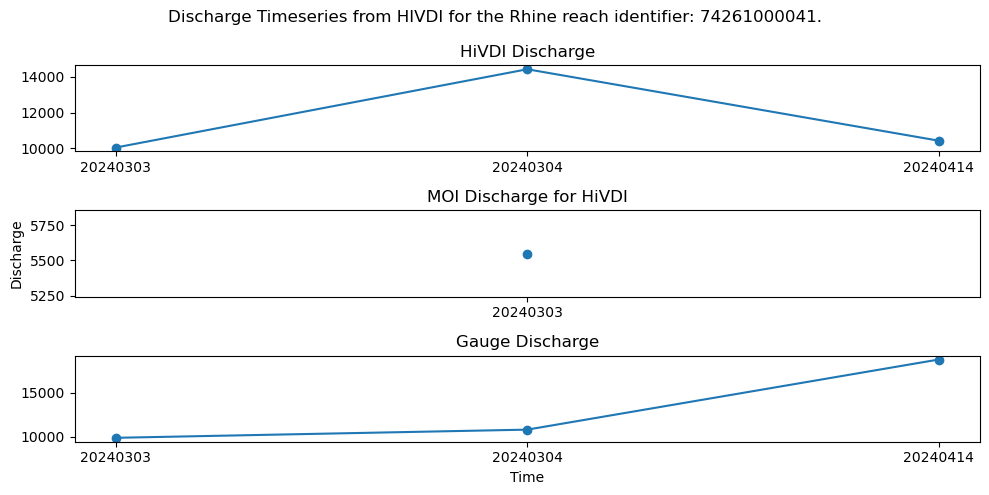

In [28]:
# Plot HiVDI discharge alongside MOI discharge

fig = plt.figure(figsize=(10,5))

# HiVDI Q
ax1 = plt.subplot(311)
ax1.scatter(hivdi_time, hivdi_discharge)
ax1.plot(hivdi_time, hivdi_discharge)

# MOI Q
ax2 = plt.subplot(312)
ax2.scatter(hivdi_time, moi_hivdi_q)
ax2.plot(hivdi_time, moi_hivdi_q)

# Gauge Q
ax3 = plt.subplot(313)
ax3.scatter(gauge_time, gauge_discharge)
ax3.plot(gauge_time, gauge_discharge)

# Define labels and title
ax2.set_ylabel('Discharge')
ax3.set_xlabel('Time')

ax1.set_title("HiVDI Discharge")
ax2.set_title("MOI Discharge for HiVDI")
ax3.set_title("Gauge Discharge")

plt.suptitle(f"Discharge Timeseries from HIVDI for the Rhine reach identifier: {reach_id}.")
plt.tight_layout()
